# Ejemplo de Clasificación con RN

- Mathias Lettere
- 14/11/2023

## Librerías

In [30]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

from sklearn.datasets import make_blobs
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import multiprocessing

import warnings
warnings.filterwarnings('ignore')

## Datos

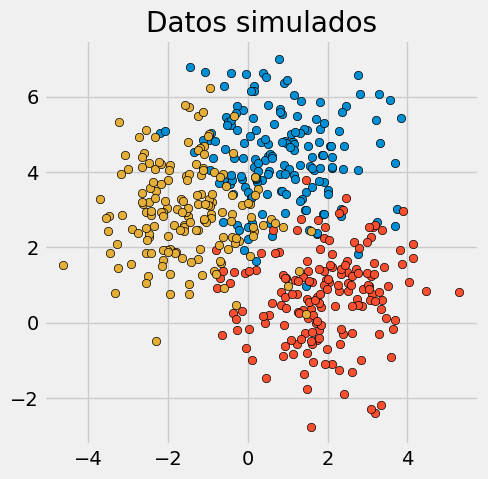

In [31]:
X, y = make_blobs(
    n_samples = 500,
    n_features = 2,
    centers = 3,
    cluster_std = 1.2,
    shuffle = True,
    random_state = 0
)

fig, ax = plt.subplots(1,1,figsize=(5,5))
for i in np.unique(y):
  ax.scatter(
      x = X[y == i, 0],
      y = X[y == i, 1],
      c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
      marker = 'o',
      edgecolor='black',
      label=f"Grupo {i}"
  )

ax.set_title('Datos simulados')
ax.legend;

## Arquitectura de la Red

In [32]:
modelo_1 = MLPClassifier(
    hidden_layer_sizes=(5),
    learning_rate_init=0.01,
    solver='lbfgs',
    max_iter = 1000,
    random_state = 123
)

modelo_2 = MLPClassifier(
    hidden_layer_sizes=(10),
    learning_rate_init=0.01,
    solver='lbfgs',
    max_iter = 1000,
    random_state = 123
)

modelo_3 = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    learning_rate_init=0.01,
    solver='lbfgs',
    max_iter = 1000,
    random_state = 123
)

modelo_4 = MLPClassifier(
    hidden_layer_sizes=(50, 50, 50),
    learning_rate_init=0.01,
    solver='lbfgs',
    max_iter = 1000,
    random_state = 123
)

modelo_1.fit(X=X, y=y)
modelo_2.fit(X=X, y=y)
modelo_3.fit(X=X, y=y)
modelo_4.fit(X=X, y=y)

MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.01,
              max_iter=1000, random_state=123, solver='lbfgs')

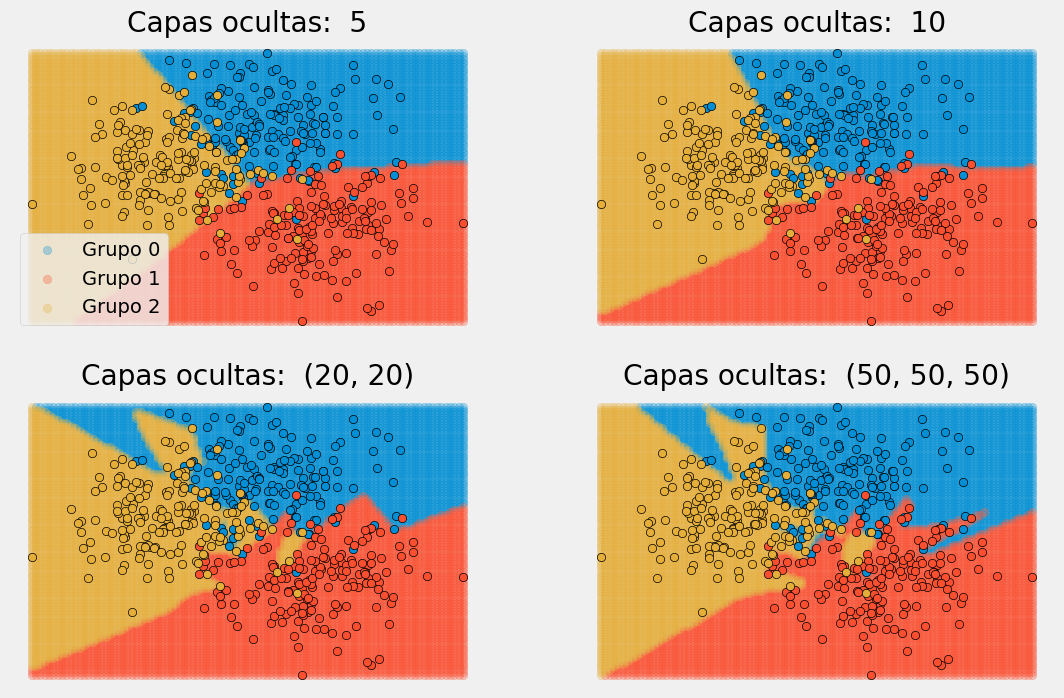

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(12,8))
axs = axs.flatten()
grid_x1 = np.linspace(start=min(X[:, 0]), stop=max(X[:, 0]), num=100)
grid_x2 = np.linspace(start=min(X[:, 1]), stop=max(X[:, 1]), num=100)

xx, yy = np.meshgrid(grid_x1, grid_x2)
X_grid = np.column_stack([xx.flatten(), yy.flatten()])

for i, modelo in enumerate([modelo_1, modelo_2, modelo_3, modelo_4]):
  predicciones = modelo.predict(X_grid)

  for j in np.unique(predicciones):
    axs[i].scatter(
        x = X_grid[predicciones == j, 0],
        y = X_grid[predicciones == j, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][j],
        alpha = 0.3,
        label = f"Grupo {j}"
    )

  for j in np.unique(y):
    axs[i].scatter(
        x = X[y == j, 0],
        y = X[y == j, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][j],
        marker = 'o',
        edgecolor = 'black'
    )

  axs[i].set_title(f"Capas ocultas:  {modelo.hidden_layer_sizes}")
  axs[i].axis('off')

axs[0].legend();

## Optimización de Hiperparámetros

In [34]:
param_grid =  {'hidden_layer_sizes':[1,5,10,15,25,50]}

grid= GridSearchCV(
    estimator = MLPClassifier(
        learning_rate_init=0.01,
        solver='lbfgs',
        alpha = 0,
        max_iter = 5000,
        random_state = 123
    ),
    param_grid = param_grid,
    scoring = 'accuracy',
    cv = 5,
    refit = True,
    return_train_score = True
)
grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=MLPClassifier(alpha=0, learning_rate_init=0.01,
                                     max_iter=5000, random_state=123,
                                     solver='lbfgs'),
             param_grid={'hidden_layer_sizes': [1, 5, 10, 15, 25, 50]},
             return_train_score=True, scoring='accuracy')

Text(0.5, 1.0, 'Error de validación cruzada')

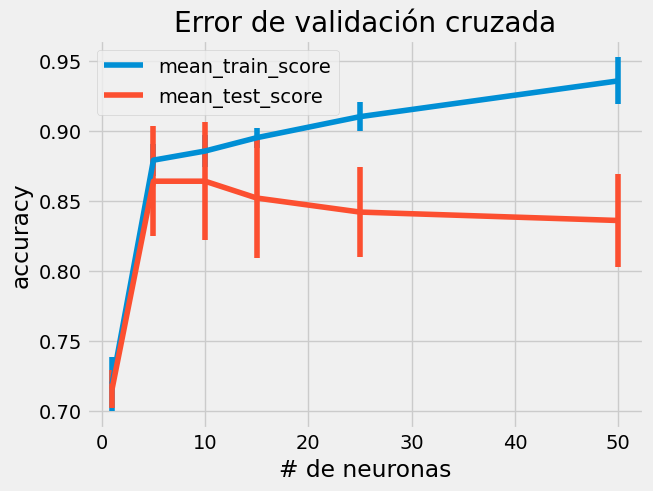

In [35]:
fig, ax = plt.subplots()
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_hidden_layer_sizes', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_hidden_layer_sizes', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_ylabel('accuracy')
ax.set_xlabel('# de neuronas')
ax.set_title('Error de validación cruzada')

In [36]:
param_grid =  {'learning_rate_init':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

grid= GridSearchCV(
    estimator = MLPClassifier(
        hidden_layer_sizes=(10),
        solver='adam',
        alpha = 0,
        max_iter = 5000,
        random_state = 123
    ),
    param_grid = param_grid,
    scoring = 'accuracy',
    cv = 5,
    refit = True,
    return_train_score = True
)
grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=MLPClassifier(alpha=0, hidden_layer_sizes=10,
                                     max_iter=5000, random_state=123),
             param_grid={'learning_rate_init': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                                100]},
             return_train_score=True, scoring='accuracy')

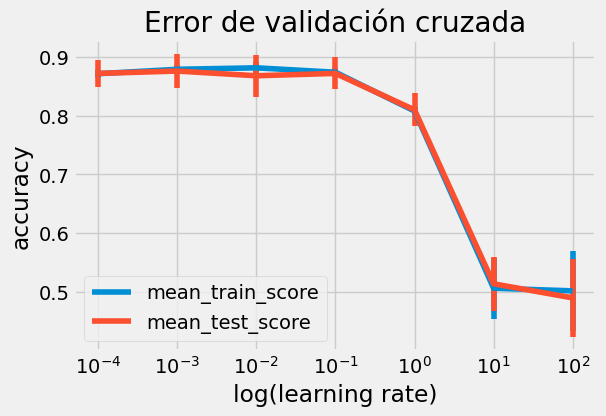

In [37]:
fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_learning_rate_init', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_learning_rate_init', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_xscale('log')
ax.set_xlabel('log(learning rate)')
ax.set_ylabel('accuracy')
ax.set_title('Error de validación cruzada');

In [38]:
param_distributions = {
    'hidden_layer_sizes':[(10),(10, 10),(20, 20)],
    'alpha': np.logspace(-3, 3, 7),
    'learning_rate_init':[0.0001, 0.001, 0.01]
    }

grid = RandomizedSearchCV(
    estimator = MLPClassifier(solver = 'lbfgs', max_iter = 2000),
    param_distributions = param_distributions,
    n_iter = 50,
    scoring = 'accuracy',
    n_jobs = multiprocessing.cpu_count() - 1,
    cv = 3,
    verbose = 0,
    random_state = 123,
    return_train_score = True
)

grid.fit(X = X, y = y)

resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex= '(param.*|mean_t|std_t)')\
                  .drop(columns = 'params')\
                  .sort_values('mean_test_score', ascending = False)\
                  .head(10)

,param_learning_rate_init,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
30,0.001,10,10.0,0.873915,0.034638,0.875978,0.021527
37,0.0001,"(10, 10)",0.001,0.869911,0.046544,0.892989,0.013583
46,0.001,10,100.0,0.869899,0.042016,0.873973,0.021077
49,0.01,10,100.0,0.869899,0.042016,0.873973,0.021077
18,0.0001,"(10, 10)",1.0,0.867891,0.050026,0.900979,0.020152
21,0.01,"(20, 20)",10.0,0.865919,0.037716,0.877977,0.022883
7,0.001,"(10, 10)",10.0,0.865919,0.037716,0.878972,0.024788
28,0.01,10,1.0,0.865895,0.047393,0.884975,0.025609
4,0.001,"(20, 20)",10.0,0.863923,0.038326,0.879979,0.023734
1,0.0001,"(10, 10)",10.0,0.863923,0.035070,0.878975,0.023916


In [39]:
modelo = grid.best_estimator_
modelo

MLPClassifier(alpha=10.0, hidden_layer_sizes=10, max_iter=2000, solver='lbfgs')

In [40]:
grid_x1 = np.linspace(start=min(X[:, 0]), stop=max(X[:, 0]), num=100)
grid_x2 = np.linspace(start=min(X[:, 1]), stop=max(X[:, 1]), num=100)

xx, yy = np.meshgrid(grid_x1, grid_x2)
X_grid = np.column_stack([xx.flatten(), yy.flatten()])
prediciones = modelo.predict(X_grid)

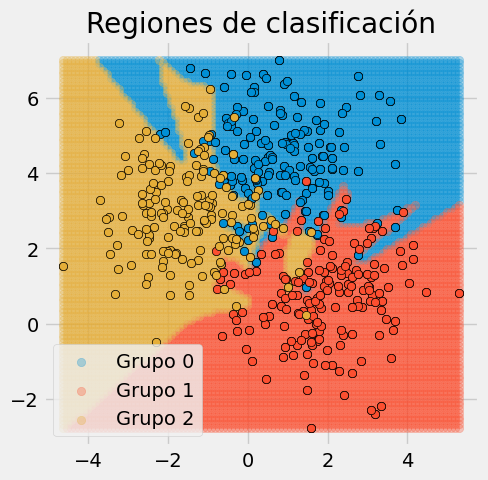

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for i in np.unique(predicciones):
    ax.scatter(
        x = X_grid[predicciones == i, 0],
        y = X_grid[predicciones == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        alpha = 0.3,
        label = f"Grupo {i}"
    )

    for i in np.unique(y):
      ax.scatter(
        x = X[y == i, 0],
        y = X[y == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker = 'o',
        edgecolor = 'black'
    )

ax.set_title('Regiones de clasificación')
ax.legend();